# Comparison between the exact algorithm and the knapsack-heuristic 

FICO Xpress v9.0.0, Hyper, solve started 16:09:12, Jul 4, 2023
Heap usage: 401KB (peak 401KB, 309KB system)
Maximizing MILP noname using up to 8 threads and up to 63GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
         1 rows          100 cols          100 elements       100 entities
Presolved problem has:
         1 rows          100 cols          100 elements       100 entities
Presolve finished in 0 seconds
Heap usage: 445KB (peak 447KB, 309KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 2.00e+00,  9.90e+01] / [ 3.13e-02,  1.55e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.69e+03] / [ 1.00e+00,  2.65e+01]
  Objective      [min,max] : [ 1.00e+00,  9.90e+01] / [ 1.00e+00,  9.90e+01]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 60.7GB
 *** Solution found:      .000000   Time:   0.00    Heuristic: T ***
 *** Solution found:  2133.00

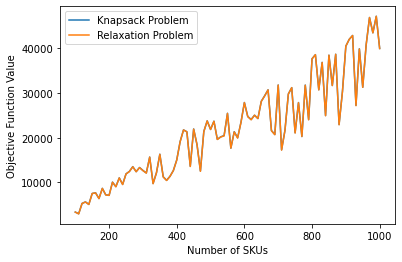

In [29]:
import xpress as xp
import random
import matplotlib.pyplot as plt

def fractional_knapsack(weights, values, capacity):
    N = len(weights)
    items = [{'weight': weights[i], 'value': values[i]} for i in range(N)]

    # Calculate the value-to-weight ratio for each item
    for item in items:
        item['ratio'] = item['value'] / item['weight']

    # Sort the items based on the ratio in descending order
    items.sort(key=lambda x: x['ratio'], reverse=True)

    total_value = 0
    knapsack = []

    for item in items:
        if item['weight'] <= capacity:
            # Take the whole item
            knapsack.append(item)
            total_value += item['value']
            capacity -= item['weight']
        else:
            break

    return knapsack, total_value

def knapsack_problem(weights, values, capacity):
    # Generate random weights and values for the items
    N = len(weights)
    # Solve the fractional knapsack problem
    fractional_knapsack(weights, values, capacity)

    # Create the Xpress problem
    prob = xp.problem()

    # Create variables
    x = [xp.var(vartype=xp.binary) for _ in range(N)]  # Binary variables for item selection
    prob.addVariable(x)

    # Set the objective function
    prob.setObjective(sum(x[i] * values[i] for i in range(N)), sense=xp.maximize)

    # Add the weight constraint
    prob.addConstraint(sum(x[i] * weights[i] for i in range(N)) <= capacity)

    # Solve the problem
    prob.solve()

    # Get the solution
    solution = prob.getSolution(x)

    return solution

# Set the range of input sizes
min_size = 100
max_size = 1000
step = 10

# Lists to store input sizes and objective function values
input_sizes = []
knapsack_objectives = []
relaxation_objectives = []

# Perform the experiment
for N in range(min_size, max_size + 1, step):
    weights = [random.randint(1, 100) for _ in range(N)]
    values = [random.randint(1, 100) for _ in range(N)]
    capacity = random.randint(N * 10, N * 40)

    # Solve the knapsack problem
    knapsack_solution = knapsack_problem(weights, values, capacity)
    knapsack_objective = sum(knapsack_solution[i] * values[i] for i in range(N))

    # Solve the relaxation problem
    relaxation_solution, relaxation_total_value = fractional_knapsack(weights, values, capacity)

    input_sizes.append(N)
    knapsack_objectives.append(knapsack_objective)
    relaxation_objectives.append(relaxation_total_value)

# Plot the curves
plt.plot(input_sizes, knapsack_objectives, label='Knapsack Problem')
plt.plot(input_sizes, relaxation_objectives, label='Relaxation Problem')
plt.xlabel('Number of SKUs')
plt.ylabel('Objective Function Value')
plt.legend()
plt.show()


# Difference between the two algorithms in terms of the objective value

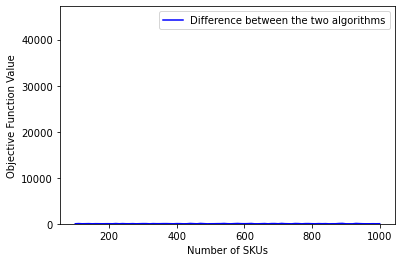

In [31]:
import numpy as np
a = (np.array(knapsack_objectives) - np.array(relaxation_objectives))
plt.plot(input_sizes,list(a), label='Difference between the two algorithms',color='blue')
#plt.plot(input_sizes, relaxation_objectives, label='Relaxation Problem',color='white')
#plt.ylim(0, max(np.array(relaxation_objectives)))
plt.xlabel('Number of SKUs')
plt.ylabel('Objective Function Value')
plt.ylim(0,max(np.array(knapsack_objectives)))
plt.legend()
plt.show()
